<a href="https://colab.research.google.com/github/daniellaeme/Face-Mask-Detection/blob/main/Face_Mask_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import load_img

In [2]:
import requests
import zipfile

url = "https://data-flair.s3.ap-south-1.amazonaws.com/Data-Science-Data/face-mask-dataset.zip"
response = requests.get(url)

with open("face_mask_detection.zip", "wb") as f:
    f.write(response.content)

with zipfile.ZipFile("face_mask_detection.zip", "r") as zip_file:
    zip_file.extractall()

import os
os.remove("face_mask_detection.zip")

In [3]:
zipped_files = ['/content/Dataset/train.zip', '/content/Dataset/test.zip']

for zipped_file in zipped_files:
  with zipfile.ZipFile(zipped_file, "r") as zip_file:
    zip_file.extractall()

In [4]:
BATCH_SIZE = 10

train_dir = './train'

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=BATCH_SIZE,
                                                    target_size=(150, 150))

validation_dir = './test'

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                  batch_size=BATCH_SIZE,
                                                  target_size=(150, 150))

Found 1315 images belonging to 2 classes.
Found 194 images belonging to 2 classes.


# Model Development

In [5]:
model = Sequential([
    Conv2D(100, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),

    Conv2D(100, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dropout(0.5),
    Dense(50, activation='relu'),
    Dense(2, activation='softmax'),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 100)     2800      
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 100)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 100)       90100     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 100)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 129600)            0         
                                                                 
 dropout (Dropout)           (None, 129600)            0

In [6]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

In [7]:
checkpoint = ModelCheckpoint('model2-{epoch:03d}.model',
                             monitor='val_loss',
                             verbose=0,
                             save_best_only=True,
                             mode='auto')

In [8]:
EPOCHS = 10

history = model.fit(train_generator,
                    epochs=EPOCHS,
                    validation_data=validation_generator,
                    callbacks=[checkpoint])

Epoch 1/10
132/132 [==============================] - 26s 110ms/step - loss: 0.5831 - acc: 0.7042 - val_loss: 0.4120 - val_acc: 0.8402
Epoch 2/10
132/132 [==============================] - 13s 101ms/step - loss: 0.4142 - acc: 0.8525 - val_loss: 0.1737 - val_acc: 0.9330
Epoch 3/10
132/132 [==============================] - 14s 108ms/step - loss: 0.3029 - acc: 0.8905 - val_loss: 0.1501 - val_acc: 0.9588
Epoch 4/10
132/132 [==============================] - 14s 104ms/step - loss: 0.2903 - acc: 0.8905 - val_loss: 0.0898 - val_acc: 0.9794
Epoch 5/10
132/132 [==============================] - 13s 99ms/step - loss: 0.2559 - acc: 0.8989 - val_loss: 0.1119 - val_acc: 0.9485
Epoch 6/10
132/132 [==============================] - 14s 108ms/step - loss: 0.2335 - acc: 0.9103 - val_loss: 0.0877 - val_acc: 0.9691
Epoch 7/10
132/132 [==============================] - 14s 103ms/step - loss: 0.2225 - acc: 0.9171 - val_loss: 0.1003 - val_acc: 0.9639
Epoch 8/10
132/132 [==============================] - 13

# Accuracy

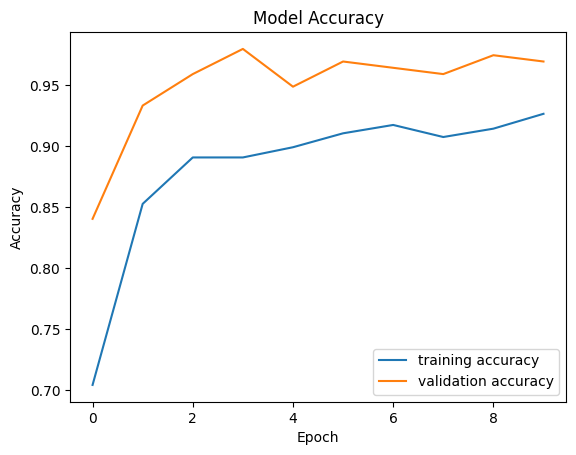

In [9]:
train_accuracy = model.history.history['acc']
val_accuracy = model.history.history['val_acc']

plt.plot(train_accuracy, label='training accuracy')
plt.plot(val_accuracy, label='validation accuracy')

plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Training accuracy = 92.62%
Validation accuracy = 96.91%

# Save model

In [10]:
model.save('face_mask_detection_model.keras')

# Predictions

In [11]:
my_model = load_model('face_mask_detection_model.keras')

In [12]:
def predict_image(image_path, target_size=(150, 150, 3)):
  test_image = load_img(image_path, target_size=target_size)
  plt.imshow(test_image)
  test_image = img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis=0)
  print(my_model.predict(test_image))

1/1 [==============================] - 0s 273ms/step
[[1. 0.]]


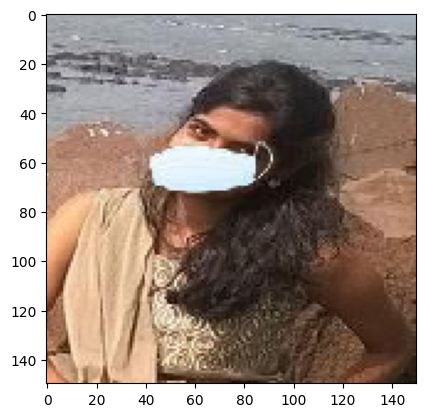

In [13]:
predict_image('/content/test/with_mask/449-with-mask.jpg')

1/1 [==============================] - 0s 31ms/step
[[0. 1.]]


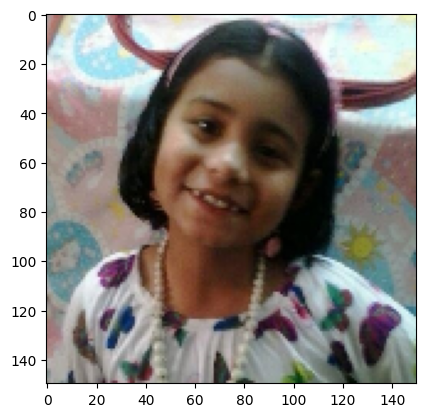

In [14]:
predict_image('/content/test/without_mask/58.jpg')